In [135]:

# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.dates as mdates
import seaborn as sns

from prophet import Prophet
from prophet.plot import plot_seasonality , plot_weekly, plot_yearly

from matplotlib import pyplot as plt


In [136]:
ev_load = './EV Load Profiles/EV Residential trials/EV Residential trials/212175552.csv'

EV_DATA=pd.read_csv(ev_load ,  nrows=1000000)

EV_DATA

,SerialNo,ReadingDate,Import Wh Total,THD Voltage Main Minimum,Q3 Wh Total,Current Main Maximum,THD Current Main Minimum,Current Main Minimum,Voltage Main Maximum,Signal Strength,...,Active Power Total (Watts),System Frequency,THD Voltage Main Maximum,Q4 Wh Total,Apparant Power Total (VA),Reactive Power Total (vars),Voltage Main Minimum,Q2 Wh Total,THD Current Main Maximum,Export Wh Total
0,212175552,09/01/2013 23:00:00,0.0,NaN,0.0,0.2,NaN,0.0,248.575,15.524,...,NaN,49.957,NaN,0.0,0.0,NaN,243.937,0.0,NaN,0.0
1,212175552,09/01/2013 23:10:00,NaN,NaN,0.0,0.0,NaN,0.0,247.307,18.138,...,NaN,50.020,NaN,0.0,0.0,NaN,241.443,0.0,NaN,NaN
2,212175552,09/01/2013 23:20:00,NaN,NaN,0.0,0.0,NaN,0.0,247.451,18.094,...,NaN,49.980,NaN,0.0,0.0,NaN,242.525,0.0,NaN,NaN
3,212175552,09/01/2013 23:30:00,0.0,NaN,0.0,0.0,NaN,0.0,246.503,17.996,...,NaN,50.012,NaN,0.0,0.0,NaN,241.309,0.0,NaN,0.0
4,212175552,09/01/2013 23:40:00,NaN,NaN,0.0,0.0,NaN,0.0,246.647,18.094,...,NaN,49.949,NaN,0.0,0.0,NaN,242.896,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30327,212175552,22/08/2013 00:20:00,0.0,3.054,NaN,0.0,0.0,0.0,247.812,NaN,...,0.0,NaN,3.285,NaN,0.0,0.0,244.462,NaN,0.0,0.0
30328,212175552,22/08/2013 00:30:00,0.0,3.065,NaN,0.0,0.0,0.0,246.019,NaN,...,0.0,NaN,3.219,NaN,0.0,0.0,244.071,NaN,0.0,0.0
30329,212175552,22/08/2013 00:40:00,0.0,2.999,NaN,0.0,0.0,0.0,245.534,NaN,...,0.0,NaN,3.219,NaN,0.0,0.0,244.050,NaN,0.0,0.0
30330,212175552,22/08/2013 00:50:00,0.0,3.065,NaN,0.0,0.0,0.0,246.132,NaN,...,0.0,NaN,3.285,NaN,0.0,0.0,243.895,NaN,0.0,0.0


In [137]:
print(EV_DATA.columns)


Index(['SerialNo', 'ReadingDate', 'Import Wh Total',
       'THD Voltage Main Minimum', 'Q3 Wh Total', 'Current Main Maximum',
       'THD Current Main Minimum', 'Current Main Minimum',
       'Voltage Main Maximum', 'Signal Strength', 'Q1 Wh Total',
       'Voltage Total', 'Active Power Total (Watts)', 'System Frequency',
       'THD Voltage Main Maximum', 'Q4 Wh Total', 'Apparant Power Total (VA)',
       'Reactive Power Total (vars)', 'Voltage Main Minimum', 'Q2 Wh Total',
       'THD Current Main Maximum', 'Export Wh Total'],
      dtype='object')


In [138]:
# Clean the date strings (assuming the date format is '%d/%m/%Y %H:%M:%S')
EV_DATA['ReadingDate'] = EV_DATA['ReadingDate'].str.strip()

# Check for missing or invalid date strings
invalid_dates = EV_DATA[~EV_DATA['ReadingDate'].str.match(r'\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2}')]

if not invalid_dates.empty:
    # Handle missing or invalid date strings (e.g., drop them)
    EV_DATA.drop(invalid_dates.index, inplace=True)

# Convert 'ReadingDate' column to datetime
EV_DATA['ReadingDate'] = pd.to_datetime(EV_DATA['ReadingDate'], format='%d/%m/%Y %H:%M:%S')

# Filter out rows where the minute component is not on the hour mark or half hour mark
EV_DATA_30Mins = EV_DATA[(EV_DATA['ReadingDate'].dt.minute == 0) | (EV_DATA['ReadingDate'].dt.minute == 30)]

# Set the 'ReadingDate' column as the index
EV_DATA_30Mins.set_index('ReadingDate', inplace=True)

# Reset index to make 'ReadingDate' a column again
EV_DATA_30Mins.reset_index(inplace=True)

# Display the resampled DataFrame
EV_DATA_30Mins

,ReadingDate,SerialNo,Import Wh Total,THD Voltage Main Minimum,Q3 Wh Total,Current Main Maximum,THD Current Main Minimum,Current Main Minimum,Voltage Main Maximum,Signal Strength,...,Active Power Total (Watts),System Frequency,THD Voltage Main Maximum,Q4 Wh Total,Apparant Power Total (VA),Reactive Power Total (vars),Voltage Main Minimum,Q2 Wh Total,THD Current Main Maximum,Export Wh Total
0,2013-01-09 23:00:00,212175552,0.0,NaN,0.0,0.200,NaN,0.0,248.575,15.524,...,NaN,49.957,NaN,0.0,0.0,NaN,243.937,0.0,NaN,0.0
1,2013-01-09 23:30:00,212175552,0.0,NaN,0.0,0.000,NaN,0.0,246.503,17.996,...,NaN,50.012,NaN,0.0,0.0,NaN,241.309,0.0,NaN,0.0
2,2013-01-10 00:30:00,212175552,0.0,NaN,0.0,0.094,NaN,0.0,248.132,17.996,...,NaN,50.016,NaN,0.0,0.0,NaN,244.421,0.0,NaN,0.0
3,2013-01-10 01:00:00,212175552,0.0,NaN,0.0,0.000,NaN,0.0,247.513,17.996,...,NaN,49.992,NaN,0.0,0.0,NaN,244.906,0.0,NaN,0.0
4,2013-01-10 01:30:00,212175552,0.0,NaN,0.0,0.000,NaN,0.0,246.441,17.996,...,NaN,49.977,NaN,0.0,0.0,NaN,243.937,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,2013-08-21 22:30:00,212175552,0.0,3.197,NaN,0.000,0.000,0.0,247.833,NaN,...,0.0,NaN,3.417,NaN,0.0,0.0,243.195,NaN,0.000,0.0
9896,2013-08-21 23:00:00,212175552,0.0,3.142,NaN,0.053,-322.548,0.0,247.080,NaN,...,0.0,NaN,3.417,NaN,0.0,0.0,243.246,NaN,331.194,0.0
9897,2013-08-21 23:30:00,212175552,0.0,3.131,NaN,0.057,-355.265,0.0,247.018,NaN,...,0.0,NaN,3.285,NaN,0.0,0.0,245.029,NaN,339.719,0.0
9898,2013-08-22 00:30:00,212175552,0.0,3.065,NaN,0.000,0.000,0.0,246.019,NaN,...,0.0,NaN,3.219,NaN,0.0,0.0,244.071,NaN,0.000,0.0


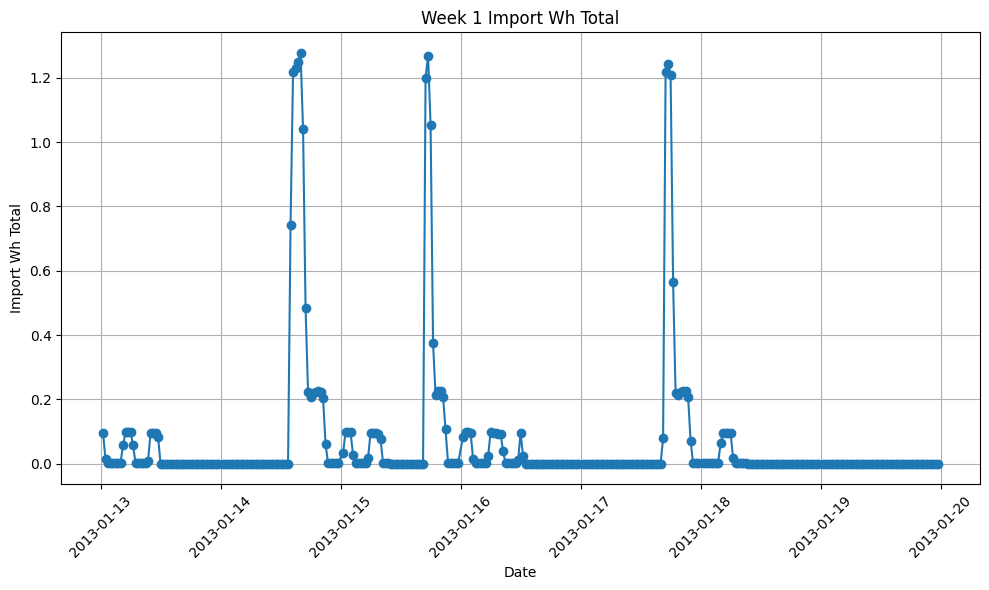

In [139]:
# Resample the data into weekly intervals
weekly_data = EV_DATA_30Mins.resample('W', on='ReadingDate').sum()

# Iterate over the first four weekly intervals and plot
for i, (start_date, end_date) in enumerate(zip(weekly_data.index, weekly_data.index[1:])):
    if i >= 1:
        break
    
    weekly_subset = EV_DATA_30Mins.loc[(EV_DATA_30Mins['ReadingDate'] >= start_date) & (EV_DATA_30Mins['ReadingDate'] < end_date)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_subset['ReadingDate'], weekly_subset['Import Wh Total'], marker='o', linestyle='-')
    plt.title(f'Week {i+1} Import Wh Total')
    plt.xlabel('Date')
    plt.ylabel('Import Wh Total')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [140]:
EV_DATA

,SerialNo,ReadingDate,Import Wh Total,THD Voltage Main Minimum,Q3 Wh Total,Current Main Maximum,THD Current Main Minimum,Current Main Minimum,Voltage Main Maximum,Signal Strength,...,Active Power Total (Watts),System Frequency,THD Voltage Main Maximum,Q4 Wh Total,Apparant Power Total (VA),Reactive Power Total (vars),Voltage Main Minimum,Q2 Wh Total,THD Current Main Maximum,Export Wh Total
0,212175552,2013-01-09 23:00:00,0.0,NaN,0.0,0.2,NaN,0.0,248.575,15.524,...,NaN,49.957,NaN,0.0,0.0,NaN,243.937,0.0,NaN,0.0
1,212175552,2013-01-09 23:10:00,NaN,NaN,0.0,0.0,NaN,0.0,247.307,18.138,...,NaN,50.020,NaN,0.0,0.0,NaN,241.443,0.0,NaN,NaN
2,212175552,2013-01-09 23:20:00,NaN,NaN,0.0,0.0,NaN,0.0,247.451,18.094,...,NaN,49.980,NaN,0.0,0.0,NaN,242.525,0.0,NaN,NaN
3,212175552,2013-01-09 23:30:00,0.0,NaN,0.0,0.0,NaN,0.0,246.503,17.996,...,NaN,50.012,NaN,0.0,0.0,NaN,241.309,0.0,NaN,0.0
4,212175552,2013-01-09 23:40:00,NaN,NaN,0.0,0.0,NaN,0.0,246.647,18.094,...,NaN,49.949,NaN,0.0,0.0,NaN,242.896,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30327,212175552,2013-08-22 00:20:00,0.0,3.054,NaN,0.0,0.0,0.0,247.812,NaN,...,0.0,NaN,3.285,NaN,0.0,0.0,244.462,NaN,0.0,0.0
30328,212175552,2013-08-22 00:30:00,0.0,3.065,NaN,0.0,0.0,0.0,246.019,NaN,...,0.0,NaN,3.219,NaN,0.0,0.0,244.071,NaN,0.0,0.0
30329,212175552,2013-08-22 00:40:00,0.0,2.999,NaN,0.0,0.0,0.0,245.534,NaN,...,0.0,NaN,3.219,NaN,0.0,0.0,244.050,NaN,0.0,0.0
30330,212175552,2013-08-22 00:50:00,0.0,3.065,NaN,0.0,0.0,0.0,246.132,NaN,...,0.0,NaN,3.285,NaN,0.0,0.0,243.895,NaN,0.0,0.0


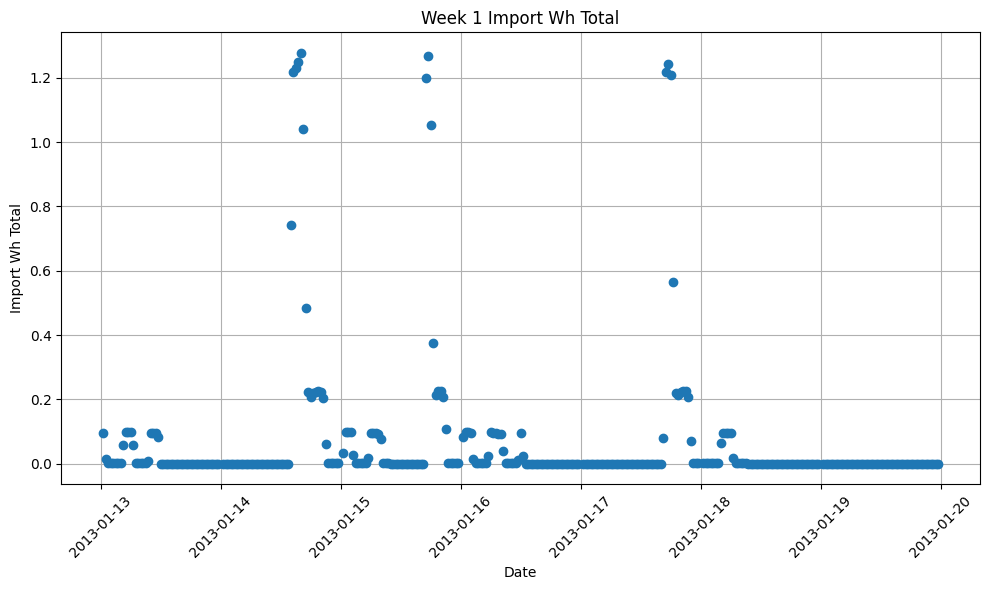

In [141]:
# Resample the data into weekly intervals
weekly_data = EV_DATA.resample('W', on='ReadingDate').sum()

# Iterate over the first four weekly intervals and plot
for i, (start_date, end_date) in enumerate(zip(weekly_data.index, weekly_data.index[1:])):
    if i >= 1:
        break
    
    weekly_subset = EV_DATA.loc[(EV_DATA['ReadingDate'] >= start_date) & (EV_DATA['ReadingDate'] < end_date)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_subset['ReadingDate'], weekly_subset['Import Wh Total'], marker='o', linestyle='-')
    plt.title(f'Week {i+1} Import Wh Total')
    plt.xlabel('Date')
    plt.ylabel('Import Wh Total')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from nilmtk import DataSet
%matplotlib inline

ds = DataSet('random.h5')
elec = ds.buildings[1].elec

print(elec)
plt.plot(elec[1].power_series_all_data())
